In [1]:
INPUT_PATH = "/home/prateek/raid_drive/datasets/ich_segmentation/data/image"
LABEL_PATH = "/home/prateek/raid_drive/datasets/ich_segmentation/data/label"
%matplotlib inline

In [2]:
# !conda install scikit-learn -y

In [3]:
import torch
import matplotlib.pyplot as plt
from pydicom import dcmread 
import PIL
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [83]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2" #GPU #2

In [84]:
import pathlib
input_list = list(pathlib.Path(INPUT_PATH).rglob("*.png"))
# print(len(input_list))
input_filenames = [os.path.basename(i) for i in input_list]
input_filenames[0:5], len(input_filenames)

(['1903.png', '1702.png', '719.png', '2084.png', '665.png'], 2814)

In [85]:
from sklearn.model_selection import train_test_split
inputs = {}
inputs["train"], inputs["val"] = train_test_split(input_filenames, test_size=0.2)
len(inputs["train"]),len(inputs["val"])

(2251, 563)

In [86]:
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomPerspective(),
#     transforms.RandomResizedCrop(size=(224,224)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [87]:
val_tf = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(45),
    # transforms.RandomPerspective(),
#     transforms.RandomResizedCrop(size=(224,224)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [88]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class SliceDatasetBinary(Dataset):
    def __init__(self, image_list:list, image_path:str, label_path:str, image_size=(224, 224), transform=None):
        self.image_list = image_list
        self.image_path = image_path
        self.label_path = label_path
        self.transform = transform
        self.image_size = image_size
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx:int)->torch.Tensor:
        filename = self.image_list[idx]
        image_path = f"{self.image_path}/{filename}"
        label_path = f"{self.label_path}/{filename}"
        image = Image.open(image_path).resize(self.image_size, PIL.Image.LANCZOS)
        label = Image.open(label_path).resize(self.image_size, PIL.Image.LANCZOS)
        sample = {"image": transforms.ToTensor()(image), "label": transforms.ToTensor()(label)}
        if self.transform != None:
            sample = self.transform(sample)
            print(type(sample))
        return(sample)

In [89]:
dataset = {}
dataset["train"] = SliceDatasetBinary(image_list=inputs["train"], image_path=INPUT_PATH, label_path=LABEL_PATH, transform=None)
dataset["val"] = SliceDatasetBinary(image_list=inputs["val"], image_path=INPUT_PATH, label_path=LABEL_PATH, transform=None)



In [90]:
image = dataset["train"][9]

In [91]:
image["label"].max() > 0

tensor(False)

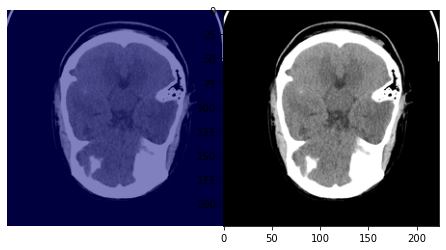

In [92]:
plt.ioff()
plt.figure() 
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.suptitle('test title', fontsize=20)
plt.subplot(1,2,1)
plt.imshow(image["image"].permute(2,1,0), cmap="gray")
plt.imshow(image["label"].permute(2,1,0), cmap="jet", alpha=0.5)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image["image"].permute(2,1,0), cmap="gray")
# plt.axis('off')
plt.savefig("test.png", dpi=400, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

In [93]:
from torch.utils.data import Dataset, DataLoader
dataloaders = {}
dataloaders['train'] = DataLoader(dataset['train'], batch_size=16, num_workers=8)
dataloaders['val'] = DataLoader(dataset['val'], batch_size=16, num_workers=8)

In [94]:
# Testing dataset import
from tqdm import tqdm
print("Train dataset")
for i in tqdm(dataloaders['train']):
    pass
print("Val dataset")
for i in tqdm(dataloaders['val']):
    pass

  0%|          | 0/141 [00:00<?, ?it/s]

Train dataset


  0%|          | 0/36 [00:00<?, ?it/s]

Val dataset


100%|██████████| 36/36 [00:01<00:00, 28.57it/s]


In [95]:
#importing a u-net
from architectures.unet import UNet

In [111]:
net = UNet(n_channels=1, n_classes=1, bilinear=True)
net.cpu()
# wandb.watch(net)
lr = 0.001
epochs = 100
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [112]:
save_file = torch.load("04A_checkpoints/checkpoint_epoch96_loss0.0005411072486706271.pth")

In [113]:
net.load_state_dict(save_file['model_state_dict'])
net.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [173]:
images = None
labels = None
outs = None
for batch in tqdm(dataloaders['val']):
    with torch.no_grad():
        image = batch['image']
        label = batch['label']
        out = net(image)
        out = out.cpu()
        if images == None:
            images = image
            labels = label
            outs = out.cpu()
        else:
            print(images.shape)
            images = torch.cat([images, image], dim=0)
            labels = torch.cat([labels, label], dim=0)
            outs = torch.cat([outs, out.cpu()], dim=0)
        image = None
        label = None
        out = None
idx = 0


  6%|▌         | 2/36 [00:07<02:00,  3.53s/it]

torch.Size([16, 1, 224, 224])


  8%|▊         | 3/36 [00:09<01:41,  3.09s/it]

torch.Size([32, 1, 224, 224])


 11%|█         | 4/36 [00:12<01:32,  2.88s/it]

torch.Size([48, 1, 224, 224])


 14%|█▍        | 5/36 [00:15<01:25,  2.75s/it]

torch.Size([64, 1, 224, 224])


 17%|█▋        | 6/36 [00:17<01:21,  2.70s/it]

torch.Size([80, 1, 224, 224])


 19%|█▉        | 7/36 [00:20<01:14,  2.58s/it]

torch.Size([96, 1, 224, 224])


 22%|██▏       | 8/36 [00:22<01:10,  2.51s/it]

torch.Size([112, 1, 224, 224])


 25%|██▌       | 9/36 [00:24<01:06,  2.45s/it]

torch.Size([128, 1, 224, 224])


 28%|██▊       | 10/36 [00:27<01:02,  2.41s/it]

torch.Size([144, 1, 224, 224])


 31%|███       | 11/36 [00:29<00:58,  2.35s/it]

torch.Size([160, 1, 224, 224])


 33%|███▎      | 12/36 [00:31<00:56,  2.35s/it]

torch.Size([176, 1, 224, 224])


 36%|███▌      | 13/36 [00:34<00:57,  2.49s/it]

torch.Size([192, 1, 224, 224])


 39%|███▉      | 14/36 [00:37<00:56,  2.57s/it]

torch.Size([208, 1, 224, 224])


 42%|████▏     | 15/36 [00:39<00:52,  2.50s/it]

torch.Size([224, 1, 224, 224])


 44%|████▍     | 16/36 [00:41<00:49,  2.45s/it]

torch.Size([240, 1, 224, 224])


 47%|████▋     | 17/36 [00:44<00:45,  2.42s/it]

torch.Size([256, 1, 224, 224])


 50%|█████     | 18/36 [00:46<00:43,  2.41s/it]

torch.Size([272, 1, 224, 224])


 53%|█████▎    | 19/36 [00:48<00:40,  2.38s/it]

torch.Size([288, 1, 224, 224])


 56%|█████▌    | 20/36 [00:51<00:39,  2.45s/it]

torch.Size([304, 1, 224, 224])


 58%|█████▊    | 21/36 [00:53<00:36,  2.42s/it]

torch.Size([320, 1, 224, 224])


 61%|██████    | 22/36 [00:56<00:33,  2.40s/it]

torch.Size([336, 1, 224, 224])


 64%|██████▍   | 23/36 [00:58<00:31,  2.39s/it]

torch.Size([352, 1, 224, 224])


 67%|██████▋   | 24/36 [01:00<00:28,  2.38s/it]

torch.Size([368, 1, 224, 224])


 69%|██████▉   | 25/36 [01:03<00:26,  2.38s/it]

torch.Size([384, 1, 224, 224])


 72%|███████▏  | 26/36 [01:05<00:24,  2.44s/it]

torch.Size([400, 1, 224, 224])


 75%|███████▌  | 27/36 [01:08<00:22,  2.54s/it]

torch.Size([416, 1, 224, 224])


 78%|███████▊  | 28/36 [01:11<00:20,  2.58s/it]

torch.Size([432, 1, 224, 224])


 81%|████████  | 29/36 [01:13<00:17,  2.53s/it]

torch.Size([448, 1, 224, 224])


 83%|████████▎ | 30/36 [01:16<00:14,  2.47s/it]

torch.Size([464, 1, 224, 224])


 86%|████████▌ | 31/36 [01:18<00:12,  2.43s/it]

torch.Size([480, 1, 224, 224])


 89%|████████▉ | 32/36 [01:20<00:09,  2.40s/it]

torch.Size([496, 1, 224, 224])


 92%|█████████▏| 33/36 [01:23<00:07,  2.38s/it]

torch.Size([512, 1, 224, 224])


 94%|█████████▍| 34/36 [01:25<00:04,  2.38s/it]

torch.Size([528, 1, 224, 224])


 97%|█████████▋| 35/36 [01:27<00:02,  2.36s/it]

torch.Size([544, 1, 224, 224])


100%|██████████| 36/36 [01:28<00:00,  2.45s/it]

torch.Size([560, 1, 224, 224])


In [558]:
def jaccard(label, generated):
    if label.sum() == 0 and generated.sum() == 0:
        return "NA"
    else:
        intersection = torch.logical_and(label, generated)
        union = torch.logical_or(label, generated)
        print(intersection.sum(), union.sum())
        iou_score = torch.true_divide(intersection.sum(),union.sum())
        print('IoU is %s' % iou_score)
        return(iou_score)

In [559]:
def truth_table(label, generated):
    label_sum = label.sum()
    generated_sum = generated.sum()
    if label_sum == 0:
        if generated_sum == 0:
            return("TN")
        else:
            return("FP")
    else:
        if generated_sum == 0:
            return("FN")
        else:
            return("TP")

In [918]:
import numpy as np
start_point = 0
truth_figures = []
jaccards = []

In [910]:
for idx in tqdm(range(start_point, images.shape[0])):
    truth_figures.append(truth_table(labels[idx], outs[idx]>0.5))
    jaccards.append(jaccard(labels[idx], outs[idx]>0.5))

 36%|███▌      | 200/563 [00:00<00:00, 929.68it/s]

tensor(24) tensor(124)
IoU is tensor(0.1935)
tensor(179) tensor(383)
IoU is tensor(0.4674)
tensor(1808) tensor(2603)
IoU is tensor(0.6946)
tensor(41) tensor(151)
IoU is tensor(0.2715)
tensor(759) tensor(1015)
IoU is tensor(0.7478)
tensor(268) tensor(488)
IoU is tensor(0.5492)
tensor(14) tensor(85)
IoU is tensor(0.1647)
tensor(53) tensor(164)
IoU is tensor(0.3232)
tensor(15) tensor(890)
IoU is tensor(0.0169)
tensor(554) tensor(1307)
IoU is tensor(0.4239)
tensor(0) tensor(84)
IoU is tensor(0.)
tensor(333) tensor(805)
IoU is tensor(0.4137)
tensor(0) tensor(395)
IoU is tensor(0.)
tensor(23) tensor(113)
IoU is tensor(0.2035)
tensor(106) tensor(291)
IoU is tensor(0.3643)
tensor(0) tensor(134)
IoU is tensor(0.)
tensor(78) tensor(655)
IoU is tensor(0.1191)
tensor(417) tensor(692)
IoU is tensor(0.6026)
tensor(1147) tensor(1538)
IoU is tensor(0.7458)
tensor(40) tensor(369)
IoU is tensor(0.1084)
tensor(0) tensor(66)
IoU is tensor(0.)
tensor(16) tensor(135)
IoU is tensor(0.1185)
tensor(142) tensor

 69%|██████▉   | 388/563 [00:00<00:00, 919.07it/s]

tensor(359) tensor(615)
IoU is tensor(0.5837)
tensor(730) tensor(1080)
IoU is tensor(0.6759)
tensor(2) tensor(77)
IoU is tensor(0.0260)
tensor(23) tensor(118)
IoU is tensor(0.1949)
tensor(494) tensor(846)
IoU is tensor(0.5839)
tensor(0) tensor(69)
IoU is tensor(0.)
tensor(1228) tensor(1795)
IoU is tensor(0.6841)
tensor(111) tensor(244)
IoU is tensor(0.4549)
tensor(0) tensor(163)
IoU is tensor(0.)
tensor(221) tensor(455)
IoU is tensor(0.4857)
tensor(54) tensor(248)
IoU is tensor(0.2177)
tensor(92) tensor(408)
IoU is tensor(0.2255)
tensor(91) tensor(322)
IoU is tensor(0.2826)
tensor(466) tensor(873)
IoU is tensor(0.5338)
tensor(372) tensor(597)
IoU is tensor(0.6231)
tensor(0) tensor(169)
IoU is tensor(0.)
tensor(0) tensor(206)
IoU is tensor(0.)
tensor(0) tensor(8)
IoU is tensor(0.)
tensor(853) tensor(1524)
IoU is tensor(0.5597)
tensor(106) tensor(292)
IoU is tensor(0.3630)
tensor(343) tensor(527)
IoU is tensor(0.6509)
tensor(0) tensor(3)
IoU is tensor(0.)
tensor(505) tensor(983)
IoU is t

100%|██████████| 563/563 [00:00<00:00, 1043.87it/s]

tensor(59) tensor(193)
IoU is tensor(0.3057)
tensor(0) tensor(25)
IoU is tensor(0.)
tensor(0) tensor(83)
IoU is tensor(0.)
tensor(175) tensor(352)
IoU is tensor(0.4972)
tensor(0) tensor(7)
IoU is tensor(0.)
tensor(72) tensor(328)
IoU is tensor(0.2195)
tensor(257) tensor(463)
IoU is tensor(0.5551)
tensor(436) tensor(820)
IoU is tensor(0.5317)
tensor(620) tensor(1140)
IoU is tensor(0.5439)
tensor(2) tensor(162)
IoU is tensor(0.0123)
tensor(963) tensor(1444)
IoU is tensor(0.6669)
tensor(54) tensor(146)
IoU is tensor(0.3699)
tensor(181) tensor(416)
IoU is tensor(0.4351)
tensor(998) tensor(1310)
IoU is tensor(0.7618)
tensor(14) tensor(114)
IoU is tensor(0.1228)
tensor(92) tensor(216)
IoU is tensor(0.4259)
tensor(139) tensor(331)
IoU is tensor(0.4199)
tensor(163) tensor(291)
IoU is tensor(0.5601)


In [917]:
import pandas as pd
pd.DataFrame(truth_figures).value_counts()

TN    499
TP     52
FP      8
FN      4
dtype: int64

In [920]:
for idx in tqdm(range(start_point, images.shape[0])):
    plt.ioff()
    truth_figures.append(truth_table(labels[idx], outs[idx]>0.5))
    jaccards.append(jaccard(labels[idx], outs[idx]>0.5))
    plt.figure(figsize=(20,6))
    plt.suptitle(f'{idx}_{truth_table(labels[idx], outs[idx]>0.5)}_{jaccard(labels[idx], outs[idx]>0.5)}')
    plt.subplot(1,3,1).set_title("Original Image")
    plt.imshow(np.rot90(images[idx].permute(1,2,0)), cmap="gray")
    plt.subplot(1,3,2).set_title("Label generated from Model")
    plt.imshow(np.rot90(images[idx].permute(1,2,0)), cmap="gray")
    plt.imshow(np.rot90(outs[idx].permute(1,2,0)) > 0.5, cmap="jet", alpha=0.5)
    plt.subplot(1,3,3).set_title("Original Label")
    plt.imshow(np.rot90(images[idx].permute(1,2,0)), cmap="gray")
    plt.imshow(np.rot90(labels[idx].permute(1,2,0)), cmap="jet", alpha=0.5)
    plt.savefig(f'./04B_outputs/{idx}_{truth_table(labels[idx], outs[idx]>0.5)}_Jaccard_{jaccard(labels[idx], outs[idx]>0.5)}.png', dpi=300)
    idx = idx+1
    plt.clf()
    plt.close()

  3%|▎         | 17/563 [00:23<12:29,  1.37s/it]

tensor(24) tensor(124)
IoU is tensor(0.1935)
tensor(24) tensor(124)
IoU is tensor(0.1935)
tensor(24) tensor(124)
IoU is tensor(0.1935)


  4%|▎         | 20/563 [00:27<12:01,  1.33s/it]

tensor(179) tensor(383)
IoU is tensor(0.4674)
tensor(179) tensor(383)
IoU is tensor(0.4674)
tensor(179) tensor(383)
IoU is tensor(0.4674)


  4%|▍         | 22/563 [00:30<12:33,  1.39s/it]

tensor(1808) tensor(2603)
IoU is tensor(0.6946)
tensor(1808) tensor(2603)
IoU is tensor(0.6946)
tensor(1808) tensor(2603)
IoU is tensor(0.6946)


  4%|▍         | 24/563 [00:33<12:14,  1.36s/it]

tensor(41) tensor(151)
IoU is tensor(0.2715)
tensor(41) tensor(151)
IoU is tensor(0.2715)
tensor(41) tensor(151)
IoU is tensor(0.2715)


  5%|▍         | 28/563 [00:39<12:47,  1.43s/it]

tensor(759) tensor(1015)
IoU is tensor(0.7478)
tensor(759) tensor(1015)
IoU is tensor(0.7478)
tensor(759) tensor(1015)
IoU is tensor(0.7478)


  5%|▌         | 29/563 [00:40<12:32,  1.41s/it]

tensor(268) tensor(488)
IoU is tensor(0.5492)
tensor(268) tensor(488)
IoU is tensor(0.5492)
tensor(268) tensor(488)
IoU is tensor(0.5492)


  9%|▉         | 50/563 [01:09<11:30,  1.35s/it]

tensor(14) tensor(85)
IoU is tensor(0.1647)
tensor(14) tensor(85)
IoU is tensor(0.1647)
tensor(14) tensor(85)
IoU is tensor(0.1647)


 15%|█▍        | 83/563 [01:53<10:40,  1.33s/it]

tensor(53) tensor(164)
IoU is tensor(0.3232)
tensor(53) tensor(164)
IoU is tensor(0.3232)
tensor(53) tensor(164)
IoU is tensor(0.3232)


 16%|█▋        | 92/563 [02:05<10:51,  1.38s/it]

tensor(15) tensor(890)
IoU is tensor(0.0169)
tensor(15) tensor(890)
IoU is tensor(0.0169)
tensor(15) tensor(890)
IoU is tensor(0.0169)


 18%|█▊        | 101/563 [02:18<10:23,  1.35s/it]

tensor(554) tensor(1307)
IoU is tensor(0.4239)
tensor(554) tensor(1307)
IoU is tensor(0.4239)
tensor(554) tensor(1307)
IoU is tensor(0.4239)


 21%|██        | 116/563 [02:38<09:54,  1.33s/it]

tensor(0) tensor(84)
IoU is tensor(0.)
tensor(0) tensor(84)
IoU is tensor(0.)
tensor(0) tensor(84)
IoU is tensor(0.)


 22%|██▏       | 125/563 [02:51<10:15,  1.40s/it]

tensor(333) tensor(805)
IoU is tensor(0.4137)
tensor(333) tensor(805)
IoU is tensor(0.4137)
tensor(333) tensor(805)
IoU is tensor(0.4137)


 22%|██▏       | 126/563 [02:52<10:05,  1.39s/it]

tensor(0) tensor(395)
IoU is tensor(0.)
tensor(0) tensor(395)
IoU is tensor(0.)
tensor(0) tensor(395)
IoU is tensor(0.)


 25%|██▍       | 139/563 [03:10<10:20,  1.46s/it]

tensor(23) tensor(113)
IoU is tensor(0.2035)
tensor(23) tensor(113)
IoU is tensor(0.2035)
tensor(23) tensor(113)
IoU is tensor(0.2035)


 26%|██▌       | 144/563 [03:16<09:30,  1.36s/it]

tensor(106) tensor(291)
IoU is tensor(0.3643)
tensor(106) tensor(291)
IoU is tensor(0.3643)
tensor(106) tensor(291)
IoU is tensor(0.3643)


 26%|██▌       | 146/563 [03:19<09:21,  1.35s/it]

tensor(0) tensor(134)
IoU is tensor(0.)
tensor(0) tensor(134)
IoU is tensor(0.)
tensor(0) tensor(134)
IoU is tensor(0.)


 28%|██▊       | 155/563 [03:31<09:44,  1.43s/it]

tensor(78) tensor(655)
IoU is tensor(0.1191)
tensor(78) tensor(655)
IoU is tensor(0.1191)
tensor(78) tensor(655)
IoU is tensor(0.1191)


 28%|██▊       | 156/563 [03:33<09:30,  1.40s/it]

tensor(417) tensor(692)
IoU is tensor(0.6026)
tensor(417) tensor(692)
IoU is tensor(0.6026)
tensor(417) tensor(692)
IoU is tensor(0.6026)


 28%|██▊       | 160/563 [03:38<08:57,  1.33s/it]

tensor(1147) tensor(1538)
IoU is tensor(0.7458)
tensor(1147) tensor(1538)
IoU is tensor(0.7458)
tensor(1147) tensor(1538)
IoU is tensor(0.7458)


 29%|██▉       | 165/563 [03:45<08:44,  1.32s/it]

tensor(40) tensor(369)
IoU is tensor(0.1084)
tensor(40) tensor(369)
IoU is tensor(0.1084)
tensor(40) tensor(369)
IoU is tensor(0.1084)


 32%|███▏      | 180/563 [04:05<08:30,  1.33s/it]

tensor(0) tensor(66)
IoU is tensor(0.)
tensor(0) tensor(66)
IoU is tensor(0.)
tensor(0) tensor(66)
IoU is tensor(0.)


 33%|███▎      | 187/563 [04:14<08:47,  1.40s/it]

tensor(16) tensor(135)
IoU is tensor(0.1185)
tensor(16) tensor(135)
IoU is tensor(0.1185)
tensor(16) tensor(135)
IoU is tensor(0.1185)


 33%|███▎      | 188/563 [04:16<08:41,  1.39s/it]

tensor(142) tensor(938)
IoU is tensor(0.1514)
tensor(142) tensor(938)
IoU is tensor(0.1514)
tensor(142) tensor(938)
IoU is tensor(0.1514)


 37%|███▋      | 210/563 [04:45<07:53,  1.34s/it]

tensor(359) tensor(615)
IoU is tensor(0.5837)
tensor(359) tensor(615)
IoU is tensor(0.5837)
tensor(359) tensor(615)
IoU is tensor(0.5837)


 37%|███▋      | 211/563 [04:47<07:52,  1.34s/it]

tensor(730) tensor(1080)
IoU is tensor(0.6759)
tensor(730) tensor(1080)
IoU is tensor(0.6759)
tensor(730) tensor(1080)
IoU is tensor(0.6759)


 38%|███▊      | 216/563 [04:53<07:45,  1.34s/it]

tensor(2) tensor(77)
IoU is tensor(0.0260)
tensor(2) tensor(77)
IoU is tensor(0.0260)
tensor(2) tensor(77)
IoU is tensor(0.0260)


 39%|███▉      | 220/563 [04:59<08:08,  1.42s/it]

tensor(23) tensor(118)
IoU is tensor(0.1949)
tensor(23) tensor(118)
IoU is tensor(0.1949)
tensor(23) tensor(118)
IoU is tensor(0.1949)


 39%|███▉      | 222/563 [05:02<07:48,  1.37s/it]

tensor(494) tensor(846)
IoU is tensor(0.5839)
tensor(494) tensor(846)
IoU is tensor(0.5839)
tensor(494) tensor(846)
IoU is tensor(0.5839)


 40%|████      | 226/563 [05:07<07:32,  1.34s/it]

tensor(0) tensor(69)
IoU is tensor(0.)
tensor(0) tensor(69)
IoU is tensor(0.)
tensor(0) tensor(69)
IoU is tensor(0.)


 40%|████      | 228/563 [05:10<07:33,  1.35s/it]

tensor(1228) tensor(1795)
IoU is tensor(0.6841)
tensor(1228) tensor(1795)
IoU is tensor(0.6841)
tensor(1228) tensor(1795)
IoU is tensor(0.6841)


 46%|████▌     | 257/563 [05:49<06:50,  1.34s/it]

tensor(111) tensor(244)
IoU is tensor(0.4549)
tensor(111) tensor(244)
IoU is tensor(0.4549)
tensor(111) tensor(244)
IoU is tensor(0.4549)


 48%|████▊     | 268/563 [06:04<06:55,  1.41s/it]

tensor(0) tensor(163)
IoU is tensor(0.)
tensor(0) tensor(163)
IoU is tensor(0.)
tensor(0) tensor(163)
IoU is tensor(0.)


 48%|████▊     | 271/563 [06:08<06:38,  1.36s/it]

tensor(221) tensor(455)
IoU is tensor(0.4857)
tensor(221) tensor(455)
IoU is tensor(0.4857)
tensor(221) tensor(455)
IoU is tensor(0.4857)


 50%|████▉     | 279/563 [06:19<06:18,  1.33s/it]

tensor(54) tensor(248)
IoU is tensor(0.2177)
tensor(54) tensor(248)
IoU is tensor(0.2177)
tensor(54) tensor(248)
IoU is tensor(0.2177)


 55%|█████▍    | 307/563 [06:57<05:40,  1.33s/it]

tensor(92) tensor(408)
IoU is tensor(0.2255)
tensor(92) tensor(408)
IoU is tensor(0.2255)
tensor(92) tensor(408)
IoU is tensor(0.2255)


 55%|█████▍    | 308/563 [06:58<05:38,  1.33s/it]

tensor(91) tensor(322)
IoU is tensor(0.2826)
tensor(91) tensor(322)
IoU is tensor(0.2826)
tensor(91) tensor(322)
IoU is tensor(0.2826)


 55%|█████▍    | 309/563 [07:00<05:39,  1.34s/it]

tensor(466) tensor(873)
IoU is tensor(0.5338)
tensor(466) tensor(873)
IoU is tensor(0.5338)
tensor(466) tensor(873)
IoU is tensor(0.5338)


 55%|█████▌    | 310/563 [07:01<05:37,  1.33s/it]

tensor(372) tensor(597)
IoU is tensor(0.6231)
tensor(372) tensor(597)
IoU is tensor(0.6231)
tensor(372) tensor(597)
IoU is tensor(0.6231)


 56%|█████▋    | 318/563 [07:12<05:36,  1.37s/it]

tensor(0) tensor(169)
IoU is tensor(0.)
tensor(0) tensor(169)
IoU is tensor(0.)
tensor(0) tensor(169)
IoU is tensor(0.)


 58%|█████▊    | 325/563 [07:21<05:20,  1.35s/it]

tensor(0) tensor(206)
IoU is tensor(0.)
tensor(0) tensor(206)
IoU is tensor(0.)
tensor(0) tensor(206)
IoU is tensor(0.)


 61%|██████    | 342/563 [07:44<04:56,  1.34s/it]

tensor(0) tensor(8)
IoU is tensor(0.)
tensor(0) tensor(8)
IoU is tensor(0.)
tensor(0) tensor(8)
IoU is tensor(0.)


 66%|██████▌   | 369/563 [08:21<04:20,  1.35s/it]

tensor(853) tensor(1524)
IoU is tensor(0.5597)
tensor(853) tensor(1524)
IoU is tensor(0.5597)
tensor(853) tensor(1524)
IoU is tensor(0.5597)


 66%|██████▋   | 373/563 [08:27<04:13,  1.34s/it]

tensor(106) tensor(292)
IoU is tensor(0.3630)
tensor(106) tensor(292)
IoU is tensor(0.3630)
tensor(106) tensor(292)
IoU is tensor(0.3630)


 68%|██████▊   | 381/563 [08:38<04:11,  1.38s/it]

tensor(343) tensor(527)
IoU is tensor(0.6509)
tensor(343) tensor(527)
IoU is tensor(0.6509)
tensor(343) tensor(527)
IoU is tensor(0.6509)


 68%|██████▊   | 383/563 [08:40<04:04,  1.36s/it]

tensor(0) tensor(3)
IoU is tensor(0.)
tensor(0) tensor(3)
IoU is tensor(0.)
tensor(0) tensor(3)
IoU is tensor(0.)


 69%|██████▊   | 387/563 [08:46<03:55,  1.34s/it]

tensor(505) tensor(983)
IoU is tensor(0.5137)
tensor(505) tensor(983)
IoU is tensor(0.5137)
tensor(505) tensor(983)
IoU is tensor(0.5137)


 70%|██████▉   | 394/563 [08:55<03:45,  1.33s/it]

tensor(59) tensor(193)
IoU is tensor(0.3057)
tensor(59) tensor(193)
IoU is tensor(0.3057)
tensor(59) tensor(193)
IoU is tensor(0.3057)


 72%|███████▏  | 408/563 [09:14<03:26,  1.33s/it]

tensor(0) tensor(25)
IoU is tensor(0.)
tensor(0) tensor(25)
IoU is tensor(0.)
tensor(0) tensor(25)
IoU is tensor(0.)


 73%|███████▎  | 410/563 [09:17<03:25,  1.34s/it]

tensor(0) tensor(83)
IoU is tensor(0.)
tensor(0) tensor(83)
IoU is tensor(0.)
tensor(0) tensor(83)
IoU is tensor(0.)


 74%|███████▍  | 417/563 [09:26<03:16,  1.34s/it]

tensor(175) tensor(352)
IoU is tensor(0.4972)
tensor(175) tensor(352)
IoU is tensor(0.4972)
tensor(175) tensor(352)
IoU is tensor(0.4972)


 75%|███████▍  | 422/563 [09:33<03:07,  1.33s/it]

tensor(0) tensor(7)
IoU is tensor(0.)
tensor(0) tensor(7)
IoU is tensor(0.)
tensor(0) tensor(7)
IoU is tensor(0.)


 76%|███████▌  | 428/563 [09:41<03:09,  1.40s/it]

tensor(72) tensor(328)
IoU is tensor(0.2195)
tensor(72) tensor(328)
IoU is tensor(0.2195)
tensor(72) tensor(328)
IoU is tensor(0.2195)


 79%|███████▉  | 445/563 [10:05<02:46,  1.41s/it]

tensor(257) tensor(463)
IoU is tensor(0.5551)
tensor(257) tensor(463)
IoU is tensor(0.5551)
tensor(257) tensor(463)
IoU is tensor(0.5551)


 82%|████████▏ | 462/563 [10:28<02:17,  1.37s/it]

tensor(436) tensor(820)
IoU is tensor(0.5317)
tensor(436) tensor(820)
IoU is tensor(0.5317)
tensor(436) tensor(820)
IoU is tensor(0.5317)


 83%|████████▎ | 465/563 [10:32<02:12,  1.35s/it]

tensor(620) tensor(1140)
IoU is tensor(0.5439)
tensor(620) tensor(1140)
IoU is tensor(0.5439)
tensor(620) tensor(1140)
IoU is tensor(0.5439)


 84%|████████▍ | 474/563 [10:44<01:58,  1.33s/it]

tensor(2) tensor(162)
IoU is tensor(0.0123)
tensor(2) tensor(162)
IoU is tensor(0.0123)
tensor(2) tensor(162)
IoU is tensor(0.0123)


 86%|████████▌ | 484/563 [10:58<01:47,  1.36s/it]

tensor(963) tensor(1444)
IoU is tensor(0.6669)
tensor(963) tensor(1444)
IoU is tensor(0.6669)
tensor(963) tensor(1444)
IoU is tensor(0.6669)


 86%|████████▌ | 485/563 [10:59<01:45,  1.35s/it]

tensor(54) tensor(146)
IoU is tensor(0.3699)
tensor(54) tensor(146)
IoU is tensor(0.3699)
tensor(54) tensor(146)
IoU is tensor(0.3699)


 88%|████████▊ | 494/563 [11:11<01:33,  1.35s/it]

tensor(181) tensor(416)
IoU is tensor(0.4351)
tensor(181) tensor(416)
IoU is tensor(0.4351)
tensor(181) tensor(416)
IoU is tensor(0.4351)


 93%|█████████▎| 523/563 [11:51<00:57,  1.44s/it]

tensor(998) tensor(1310)
IoU is tensor(0.7618)
tensor(998) tensor(1310)
IoU is tensor(0.7618)
tensor(998) tensor(1310)
IoU is tensor(0.7618)


 94%|█████████▍| 530/563 [12:00<00:44,  1.34s/it]

tensor(14) tensor(114)
IoU is tensor(0.1228)
tensor(14) tensor(114)
IoU is tensor(0.1228)
tensor(14) tensor(114)
IoU is tensor(0.1228)


 96%|█████████▌| 539/563 [12:12<00:34,  1.44s/it]

tensor(92) tensor(216)
IoU is tensor(0.4259)
tensor(92) tensor(216)
IoU is tensor(0.4259)
tensor(92) tensor(216)
IoU is tensor(0.4259)


 96%|█████████▌| 540/563 [12:14<00:32,  1.41s/it]

tensor(139) tensor(331)
IoU is tensor(0.4199)
tensor(139) tensor(331)
IoU is tensor(0.4199)
tensor(139) tensor(331)
IoU is tensor(0.4199)


 98%|█████████▊| 552/563 [12:29<00:14,  1.30s/it]

tensor(163) tensor(291)
IoU is tensor(0.5601)
tensor(163) tensor(291)
IoU is tensor(0.5601)
tensor(163) tensor(291)
IoU is tensor(0.5601)


100%|██████████| 563/563 [12:44<00:00,  1.36s/it]


In [39]:
import numpy as np
test = np.ones((16,1,224,224))

In [ ]:
net(test)